In [1]:
import tabix
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import tqdm.auto as tqdm
sys.path.append(
    os.path.abspath(
        os.path.join(
            "/data/pushkare/Chromatin_modules/4.quantify_3D_interactions", "src"
        )
    )
)
import utils

import peak_matrix_visualization as pmv
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Clomics parameters
n_peaks = "n_peaks_200"
bg_threshold = "bg_threshold_3"
## VCMtools parameters
vcm_window = "0.5Mb"
pv_threshold = "0.001"
## PHM parameter
pp_threshold = "0.8"

In [3]:
dataset = "test_data"

methods = ["vcmtools", "clomics", "phm"]
save_files = True

hic_data = "GM12878"
interaction_type = "MicroC"  # "HiC"
resolutions = [500, 1000]

core_path = "/data/pushkare/Chromatin_modules"
genome_annotations = os.path.join(core_path, "genome_annotations")

cm_path = os.path.join(core_path, "1.mapped_CMs")
acm_scores_path = os.path.join(cm_path, "aCM_scores")
cm_peak_path = os.path.join(core_path, "2.peaks_in_CMs", "peak_files")

corr_mtx_path = os.path.join(
    core_path, "5.visualize_3D_interactions_and_peak_corr", "peak_correlations"
)

output_path = os.path.join(
    core_path,
    "5.visualize_3D_interactions_and_peak_corr",
    "CM_tracks_viz",
)
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
# Get TAD info
tad_coordinates_df = pd.read_csv(
    os.path.join(
        genome_annotations,
        "TADs_AB_compartments",
        "_".join(["GSE63525", hic_data, "TADs_with_chr.bed"]),
    ),
    sep="\t",
    header=None,
    names=["chr", "start", "end", "tad_id"],
)

In [5]:
# Get genes and exon coordinates per gene
exons_per_chr_dict = np.load(
    os.path.join(genome_annotations, "hg19", "all_gene_exon_coordinates_per_chr.npy"),
    allow_pickle=True,
).item()
protein_coding_lincRNA_genes = pd.read_csv(
    os.path.join(
        genome_annotations,
        "hg19",
        "protein_coding_linc_RNA_gene_coordinates_and_ensembl_hgnc_ids_with_chr.bed",
    ),
    sep="\t",
    header=None,
    names=[
        "chr",
        "start",
        "end",
        "strand",
        "ensembl_gene_id",
        "gene_symbol",
        "gene_type",
        "category",
    ],
)
# Get dictionary with ENSEMBL to gene symbol mapping
ens_id_gene_symbol_mapping = dict(
    zip(
        protein_coding_lincRNA_genes.loc[:, "ensembl_gene_id"],
        protein_coding_lincRNA_genes.loc[:, "gene_symbol"].str.replace(" ", ""),
    )
)
gene_symbol_coord_mapping = dict(
    zip(
        protein_coding_lincRNA_genes.loc[:, "gene_symbol"].str.replace(" ", ""),
        list(
            zip(
                protein_coding_lincRNA_genes.loc[:, "start"],
                protein_coding_lincRNA_genes.loc[:, "end"],
            )
        ),
    )
)
# Extract only protein coding genes
protein_coding_genes = protein_coding_lincRNA_genes.loc[
    protein_coding_lincRNA_genes.loc[:, "gene_type"] == "protein_coding", :
]

In [10]:
target_regions = pd.DataFrame(
    [
        [
            "chr22",
            23349145,
            23692745,
            "chr22_23349145_23692745_BCR",  # B cell receptor
            "cm76",
            "",
            "",
        ]
    ],
    columns=["chr_id", "start", "end", "pid", "cm_id", "rs_id", "LD_rs_ids"],
)

### Plot zoom-ins

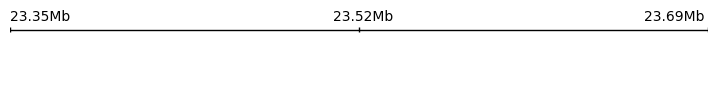

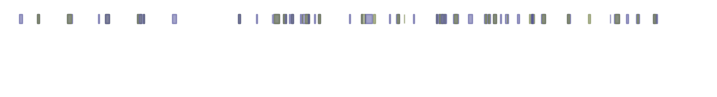

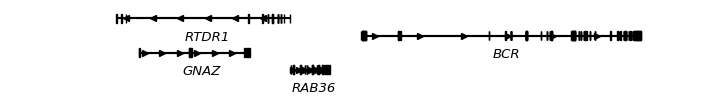

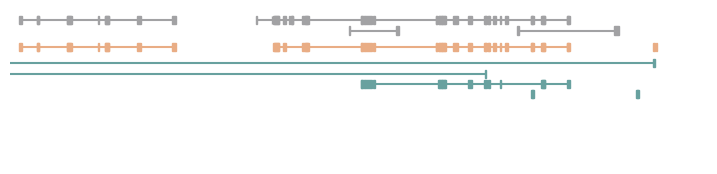

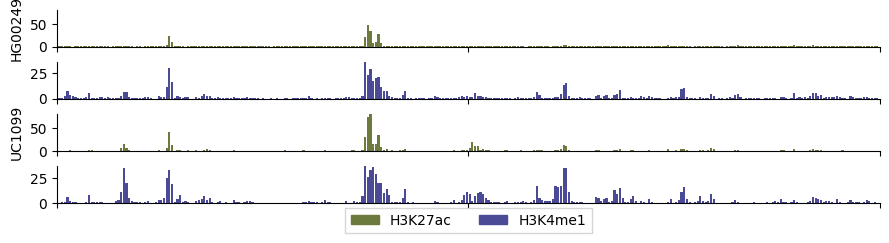

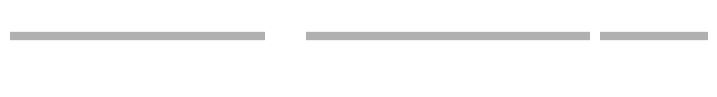

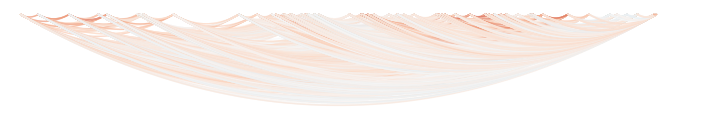

In [17]:
cms_fully_in_regions = []
query = zip(
    target_regions["chr_id"],
    target_regions["start"],
    target_regions["end"],
    target_regions["pid"],
    target_regions["cm_id"],
    target_regions["rs_id"],
    target_regions["LD_rs_ids"],
)

for chromosome, s, e, old_pid, cm_id, rs_ids, ld_rs_ids in query:
    gene_name = old_pid.split("_")[-1]
    fig_output_path = os.path.join(output_path, "plots", dataset, "zoom_in", gene_name)
    if not os.path.exists(fig_output_path):
        os.makedirs(fig_output_path)
    region_start, region_end = [s, e]
    pid = "_".join(
        [str(chromosome), str(region_start), str(region_end), gene_name, "zoom_in"]
    )
    # Clomics
    crds_in_region = utils.get_cms_in_region(
        cm_path,
        "clomics",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=False,
        n_peaks=n_peaks,
        bg_threshold=bg_threshold,
    )
    crds_fully_in_region = utils.get_cms_in_region(
        cm_path,
        "clomics",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=True,
        n_peaks=n_peaks,
        bg_threshold=bg_threshold,
    )
    # VCMtools
    vcms_in_region = utils.get_cms_in_region(
        cm_path,
        "vcmtools",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=False,
        vcm_window=vcm_window,
        pv_threshold=pv_threshold,
    )
    vcms_fully_in_region = utils.get_cms_in_region(
        cm_path,
        "vcmtools",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=True,
        vcm_window=vcm_window,
        pv_threshold=pv_threshold,
    )
    # PHM
    phms_in_region = utils.get_cms_in_region(
        cm_path,
        "phm",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=False,
        pp_threshold=pp_threshold,
    )
    phms_fully_in_region = utils.get_cms_in_region(
        cm_path,
        "phm",
        dataset,
        chromosome,
        region_start,
        region_end,
        fully_in=True,
        pp_threshold=pp_threshold,
    )

    cms_fully_in_regions.extend(crds_fully_in_region)
    cms_fully_in_regions.extend(vcms_fully_in_region)
    cms_fully_in_regions.extend(phms_fully_in_region)

    crd_peak_dict = utils.get_cm_peak_dict(
        cm_peak_path,
        method="clomics",
        dataset=dataset,
        subset=True,
        cms_to_subset=crds_in_region,
    )
    vcm_peak_dict = utils.get_cm_peak_dict(
        cm_peak_path,
        method="vcmtools",
        dataset=dataset,
        subset=True,
        cms_to_subset=vcms_in_region,
    )
    phm_peak_dict = utils.get_cm_peak_dict(
        cm_peak_path,
        method="phm",
        dataset=dataset,
        subset=True,
        cms_to_subset=phms_in_region,
    )
    # Get genes
    gene_ens_ids_in_region = (
        utils.subset_bed(
            protein_coding_genes,
            chromosome,
            region_start,
            region_end,
            fully_in=False,
        )
        .loc[:, "ensembl_gene_id"]
        .to_list()
    )
    gene_exons_dict = {
        ens_g_id: exons_per_chr_dict.get(chromosome).get(ens_g_id)
        for ens_g_id in gene_ens_ids_in_region
    }

    # Get TADs
    tad_coordinates = utils.subset_bed(
        tad_coordinates_df, chromosome, region_start, region_end, fully_in=False
    )
    tad_genomic_intervals = list(
        zip(tad_coordinates.loc[:, "start"], tad_coordinates.loc[:, "end"])
    )
    # Visualize tracks
    fig_width = 9
    pmv.plot_ruller_track(
        dataset,
        region_start,
        region_end,
        save_fig=True,
        fig_width=fig_width,
        pid=pid,
        output_path=fig_output_path,
    )

    corr_df_for_viz = pmv.prepare_data_for_corr_heatmap(
        input_path=corr_mtx_path,
        dataset=dataset,
        gene=old_pid,
        corr_file_name="correlation_matrix.txt",
        square_corr=False,
    )
    pmv.plot_peaks(
        dataset,
        corr_df_for_viz.index.to_list(),
        region_start,
        region_end,
        format_="string",
        peak_height=0.5,
        fig_width=fig_width,
        save_fig=True,
        pid=pid,
        output_path=fig_output_path,
    )
    pmv.plot_genes(
        dataset,
        region_start,
        region_end,
        gene_exon_coordinates=gene_exons_dict,
        ens_id_gene_symbol_mapping=ens_id_gene_symbol_mapping,
        gene_height=0.5,
        fig_width=fig_width,
        text_shift=-1.3,
        pid=pid,
        save_fig=True,
        zoom_in=True,
        output_path=fig_output_path,
    )
    pmv.plot_CMs_rs(
        region_start,
        region_end,
        dataset,
        pid,
        cm_height=0.4,
        fig_width=fig_width,
        save_fig=True,
        plot_variant=False,
        crd_dict=crd_peak_dict,
        vcm_dict=vcm_peak_dict,
        phm_dict=phm_peak_dict,
        variant_location=None,
        rs_ID=None,
        output_path=fig_output_path,
    )
    # Select the most extreme samples based on chromatin activity
    # Use clomics aCM scores as a reference:
    aCM_scores_df = utils.get_acm_df(acm_scores_path, method="clomics", dataset=dataset)
    sorted_aCM_scores = (
        aCM_scores_df.loc[cm_id.replace("~", "_"), :]
        .to_frame()
        .dropna()
        .sort_values(cm_id.replace("~", "_"))
    )

    min_samples = list(sorted_aCM_scores.iloc[:1, :].index)
    max_samples = list(sorted_aCM_scores.iloc[-1:, :].index)

    pmv.plot_several_bigwig_profiles(
        dataset,
        chromosome,
        region_start,
        region_end,
        {"min_samples": min_samples, "max_samples": max_samples},
        n_samples=len(min_samples) + len(max_samples),
        bw_path="/home/pushkare/NAS1/pushkare/delaneau_bigwig/bigwig",
        k27ac_file_name="H3K27ac_LCL.bw",
        k4me1_file_name="H3K4me1_LCL.bw",
        save_fig=True,
        fig_width=fig_width,
        output_path=fig_output_path,
        pid=pid,
    )
    pmv.plot_TADs(
        dataset,
        region_start,
        region_end,
        tad_genomic_intervals,
        fig_width=fig_width,
        pid=pid,
        save_fig=True,
        output_path=fig_output_path,
    )
    crd_peaks_in_region = [
        crd_peak for crd_peaks in crd_peak_dict.values() for crd_peak in crd_peaks
    ]
    vcm_peaks_in_region = [
        vcm_peak for vcm_peaks in vcm_peak_dict.values() for vcm_peak in vcm_peaks
    ]
    phm_peaks_in_region = [
        phm_peak for phm_peaks in phm_peak_dict.values() for phm_peak in phm_peaks
    ]
    common_peaks = crd_peaks_in_region + vcm_peaks_in_region + phm_peaks_in_region
    unique_peaks = []
    for peak in sorted(common_peaks):
        if peak in unique_peaks:
            continue
        else:
            unique_peaks.append(peak)
    corr_or_hic_peak_df = pmv.prepare_data_for_corr_heatmap(
        input_path=corr_mtx_path,
        dataset=dataset,
        gene=old_pid,
        corr_file_name="correlation_matrix.txt",
        square_corr=False,
    )
    interaction_threshold = 0
    use_cm_peaks = False
    if use_cm_peaks:
        common_peaks = unique_peaks
    else:
        common_peaks = [
            [int(peak.split(":")[-2]), int(peak.split(":")[-1])]
            for peak in corr_or_hic_peak_df.index.to_list()
        ]
    pmv.plot_arcs(
        dataset,
        chromosome,
        corr_or_hic_peak_df,
        interaction_threshold=interaction_threshold,
        common_peaks=common_peaks,
        region_start=region_start,
        region_end=region_end,
        save_fig=True,
        cmap=plt.cm.RdBu_r,
        min_val=-1,
        max_val=1,
        fig_width=fig_width,
        output_path=fig_output_path,
        pid=pid,
    )

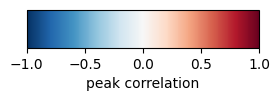

In [15]:
fig, ax = plt.subplots(figsize=(3, 1))
fig.subplots_adjust(bottom=0.5)
cmap = matplotlib.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation="horizontal",
    label="peak correlation",
)
plt.savefig(
    os.path.join(fig_output_path, "corr_colorbar.pdf"),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)